# Mapping Phonon Dispersion Relations
## Using phonopy

Phonopy has support for LAMMPS (https://phonopy.github.io/phonopy/lammps.html#how-to-handle-lammps-input-and-output-files-in-phonopy).

We start from this page. Since the crystal structure for phonopy needs to be defined in the same way as LAMMPS uses the `read_data` command, we can simply just use our original datafiles we had previously generated. 

This website was very helpful for the following explanation/intuition: https://github.com/phonopy/phonopy/tree/develop/example/Ti-lammps

### Supercell generation
After we have our datafile, we can simply run the command

    % phonopy --lammps -c unitcell.txt -d --dim 5 5 5

to generate our 5x5x5 supercell. 

**Digression** Now we should be careful here because the way phonopy works is that it takes a unit cell as an input file, then extends it out (this is what the --dim 5 5 5 means). So our unit cell is quite a simple datafile, and it would just be of the following form (for the Ti example given)
    
    2 atoms
    1 atom types
    
    0.0 2.923479689273095 xlo xhi   # xx
    0.0 2.531807678358337 ylo yhi   # yy
    0.0 4.624022835916574 zlo zhi   # zz
    
    -1.461739844636547 0.000000000000000 0.000000000000000 xy xz yz
    
    Atom Type Labels
    
    1 Ti
    
    Atoms
    
    1 Ti 0.000000000000001 1.687871785572226 3.468017126937431
    2 Ti 1.461739844636549 0.843935892786111 1.156005708979144

Here there is something new - the line which contains `xy`, `xz` and `yz`. These describe the tilt factors (see LAMMPS documentation on read_data function) and they are primarily for triclinic systems. Of course, as we are using a FCC cubic cell, these tilts are zero.

Going back to our command, if we run the command

    % phonopy --lammps -c unitcell.txt -d --dim 5 5 5

in command prompt, we generate a 5x5x5 supercell and we obtain a supercell file, which is literally identical to our LAMMPS datafiles we used to create. There was no need to do this step, but it is quite fun to see how easy it is to generate our supercells, rather than huge Python functions!

### Force calculations
Next we will need to calculate the forces between our atoms. Once again the phonopy documentation is pretty helpful with this, as it gives us an example script to calculate forces from. Of course, we will need to adapt this example script to fit our own purposes, so I just changed it to fit Lennard-Jones parameters.

Now there is a big caveat here, that phonopy works using units metal and not units real like we have been using. So we are going to need to define our Lennard-Jones parameters in terms of these units rather than the ones we were previously using. Those would need to appropriately be converted. I wasn't bothered to do this conversion by hand (not a great use of time), a mere search up gave this. I use these for now, I'll see if they're true later.

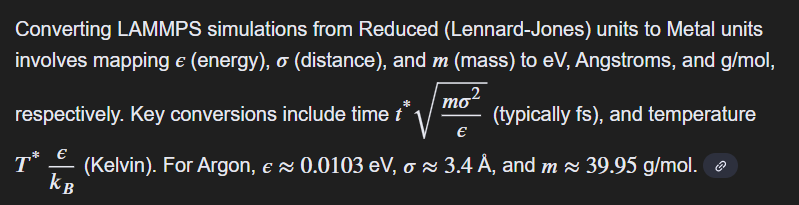

After doing that we can invoke the command

    lmp -in forces.txt

But since phonopy can sometimes produce multiple supercell files (supercell-001, supercell-002), we should instead invoke the command

    lmp -var sc XXX -in forces.txt

where XXX represents the 3-digit string at the end of the supercell txt file. Anyways, that command computes the forces between our atoms.

### Create force sets
Having obtained our force files (usually called `force.001`), we can use the following command

    % phonopy -f force.001 force.002 ... force.NNN

to generate our force sets (that's what `-f` does!)

### Creating dispersion relations

Finally by taking inspiration from the following repository,

https://github.com/phonopy/phonopy/tree/develop/example/NaCl-CRYSTAL

I created the band configuration files. We run them using the command

    phonopy -p bandconf_x.txt

for x directions, etc

## Imports

In [2]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=300 # dots per inch
import scipy as sp
import itertools
import yaml

## MONOATOMIC: Plotting phonon dispersion relation for x-path

In [100]:
# Open yaml file
with open("orderedband_x.yaml", "r") as f:
    data = yaml.safe_load(f)

In [101]:
data

{'calculator': 'lammps',
 'length_unit': 'angstrom',
 'nqpoint': 202,
 'npath': 2,
 'segment_nqpoint': [101, 101],
 'labels': [['X', 'Î“'], ['Î“', 'X']],
 'reciprocal_lattice': [[0.1860119, 0.0, 0.0],
  [0.0, 0.1860119, 0.0],
  [0.0, 0.0, 0.1860119]],
 'natom': 4,
 'lattice': [[5.376000000000001, 0.0, 0.0],
  [0.0, 5.376000000000001, 0.0],
  [0.0, 0.0, 5.376000000000001]],
 'points': [{'symbol': 'Ar', 'coordinates': [0.0, 0.0, 0.0], 'mass': 39.948},
  {'symbol': 'Ar', 'coordinates': [0.0, 0.5, 0.5], 'mass': 39.948},
  {'symbol': 'Ar', 'coordinates': [0.5, 0.0, 0.5], 'mass': 39.948},
  {'symbol': 'Ar', 'coordinates': [0.5, 0.5, 0.0], 'mass': 39.948}],
 'phonon': [{'q-position': [0.5, 0.0, 0.0],
   'distance': 0.0,
   'band': [{'frequency': 0.8143156941},
    {'frequency': 0.8143156941},
    {'frequency': 0.8143156941},
    {'frequency': 0.8143156941},
    {'frequency': 1.1185288927},
    {'frequency': 1.1185288927},
    {'frequency': 1.1319866736},
    {'frequency': 1.1319866736},
    {

We can debug using this - can see the calculator part is correct. Can see the length unit is as expected. Can see the paths I chose are good (I did X to gamma to X as usual - but the gamma label needs reworking, I am not sure what happened?). Lattice spacing looks correct, masses look correct.

In [35]:
len(data["phonon"])

202

202 = 101*2, which is expected because we had 202 points of plotting (look at data above).

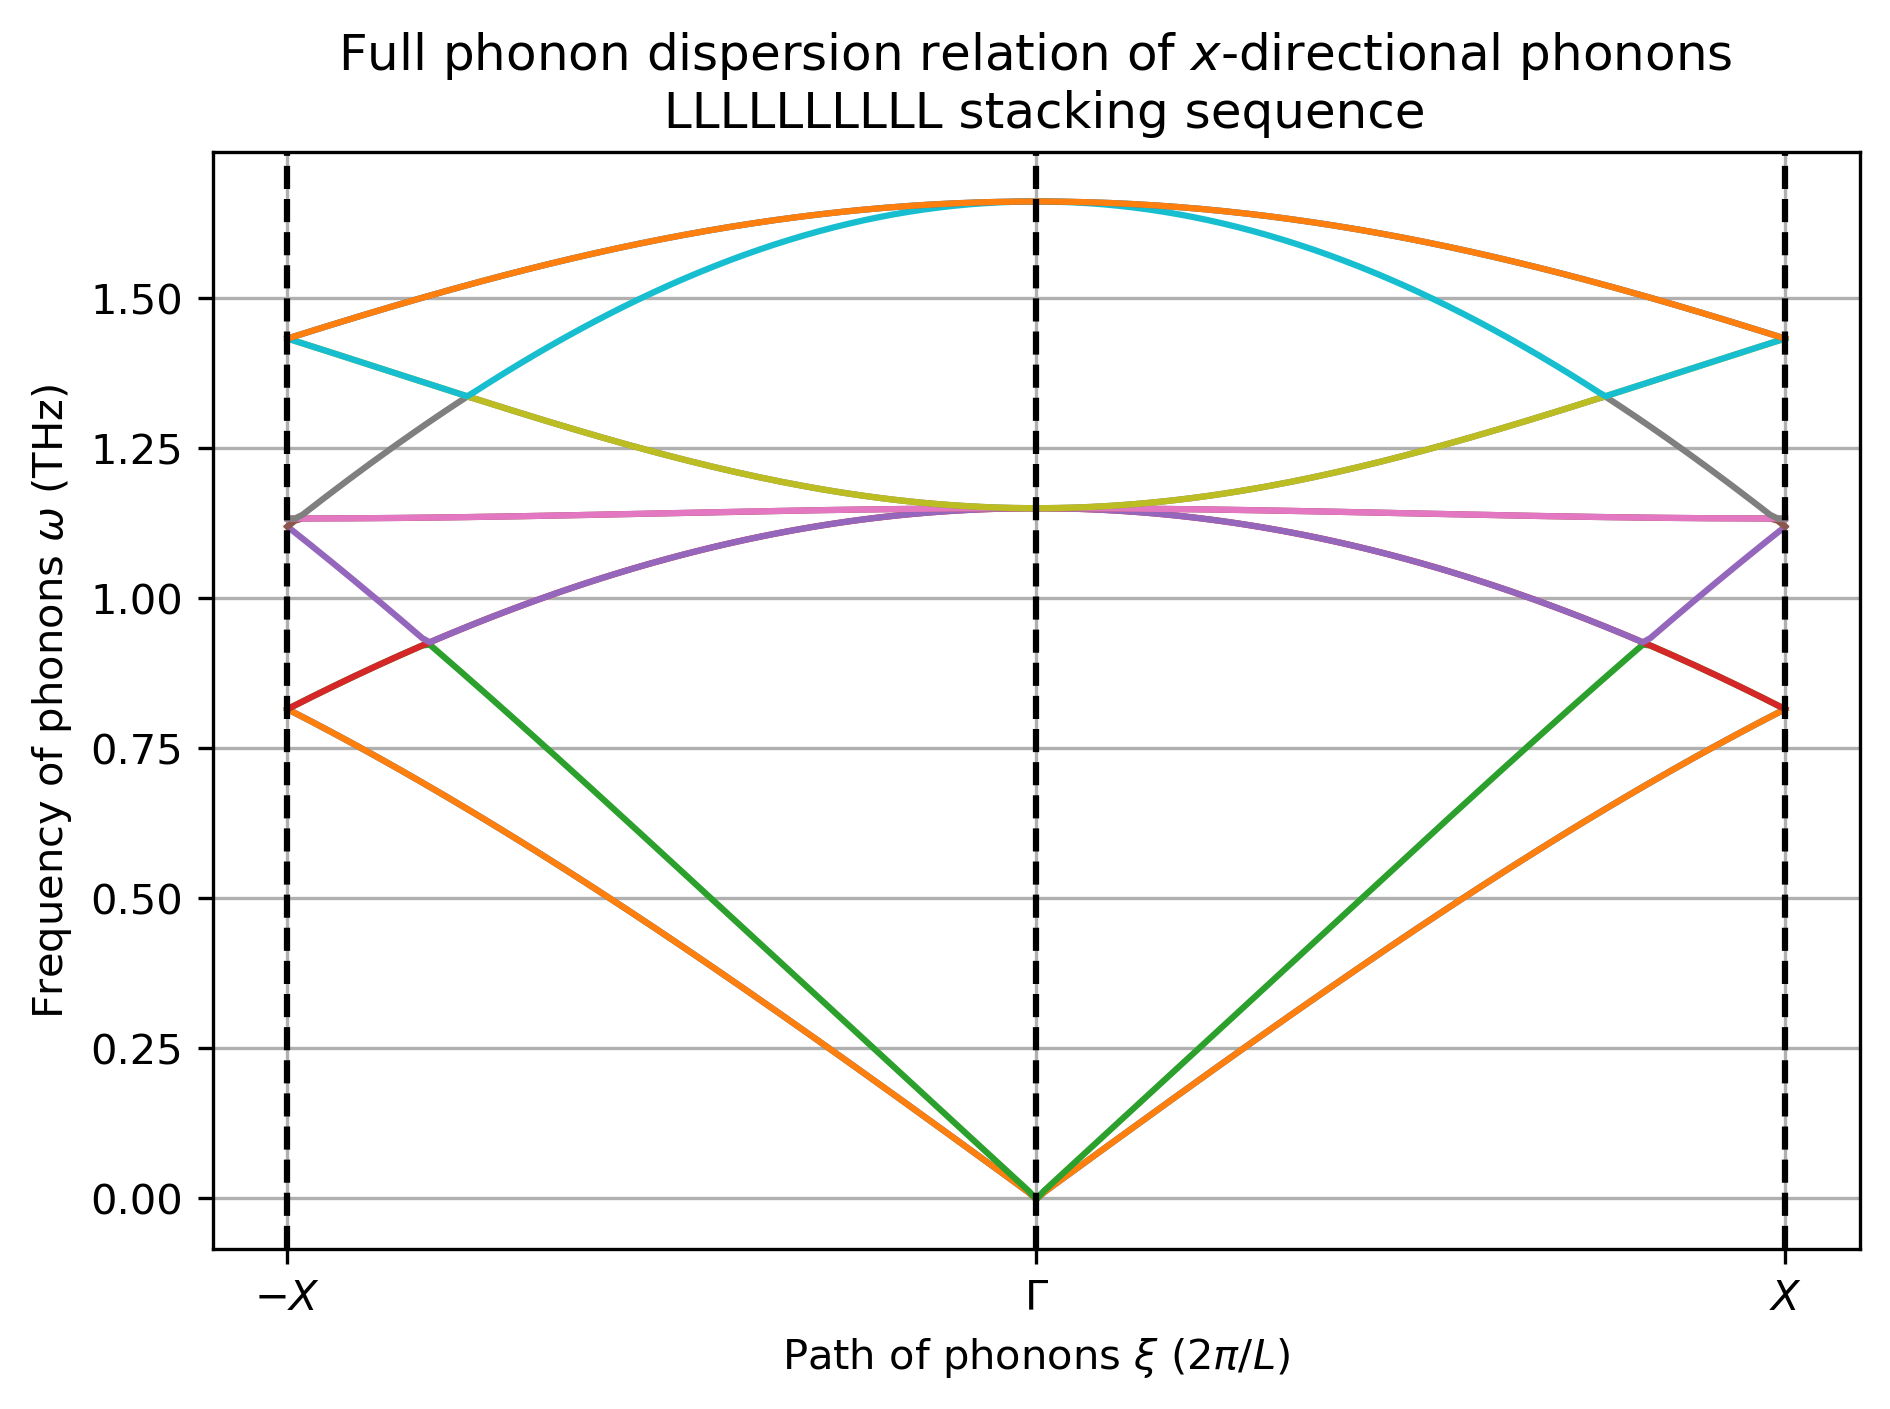

In [102]:
# Open yaml file
with open("orderedband_x.yaml", "r") as f:
    ordered_data_x = yaml.safe_load(f)

# Extract number of points and branches from yaml datafile
nqpoints = len(ordered_data_x["phonon"])
branches = 12

# Setup frequencies and paths
ordered_freqs_x = np.zeros((nqpoints, branches))
q = np.zeros(nqpoints)

# Loop over branches and points and store frequencies
for branch in range(branches):
    for point in range(nqpoints):
        ordered_freqs_x[point, branch] = ordered_data_x["phonon"][point]["band"][branch]["frequency"]
        q[point] = ordered_data_x["phonon"][point]["distance"]

plt.plot(q,ordered_freqs_x)
#plt.plot(q, LA_y, label="[010] direction (y)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Full phonon dispersion relation of $x$-directional phonons \n LLLLLLLLLL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.tight_layout()


## MONOATOMIC: Plotting phonon dispersion relation for y-path

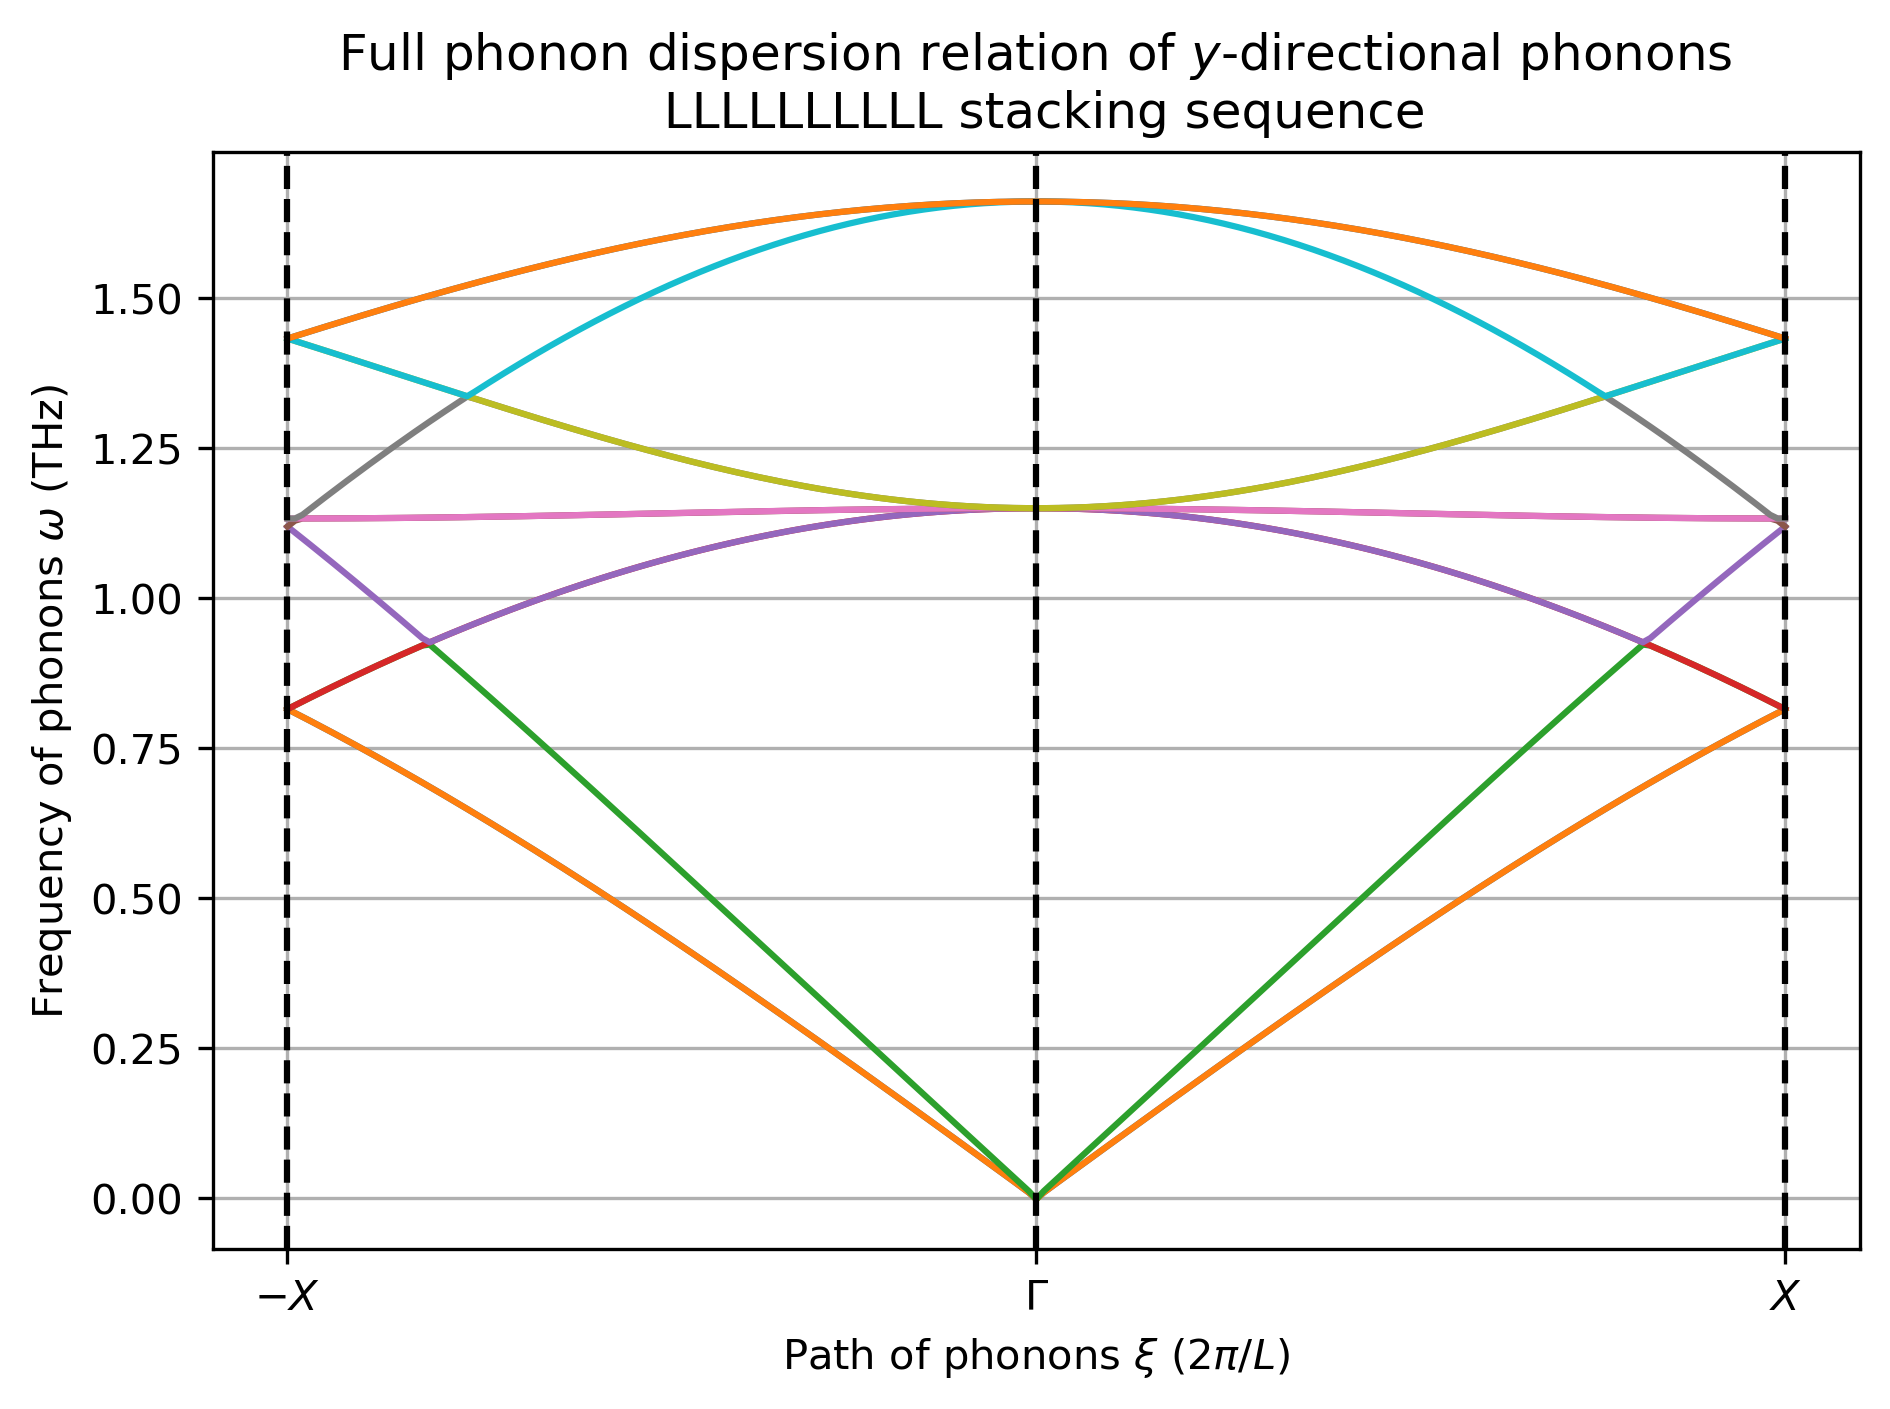

In [104]:
# Open yaml file
with open("orderedband_y.yaml", "r") as f:
    ordered_data_y = yaml.safe_load(f)

# Extract number of points and branches from yaml datafile
nqpoints = len(ordered_data_y["phonon"])
branches = 12

# Setup frequencies and paths
ordered_freqs_y = np.zeros((nqpoints, branches))
q = np.zeros(nqpoints)

# Loop over branches and points and store frequencies
for branch in range(branches):
    for point in range(nqpoints):
        ordered_freqs_y[point, branch] = ordered_data_y["phonon"][point]["band"][branch]["frequency"]
        q[point] = ordered_data_y["phonon"][point]["distance"]

plt.plot(q,ordered_freqs_y)
#plt.plot(q, LA_y, label="[010] direction (y)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Full phonon dispersion relation of $y$-directional phonons \n LLLLLLLLLL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.tight_layout()


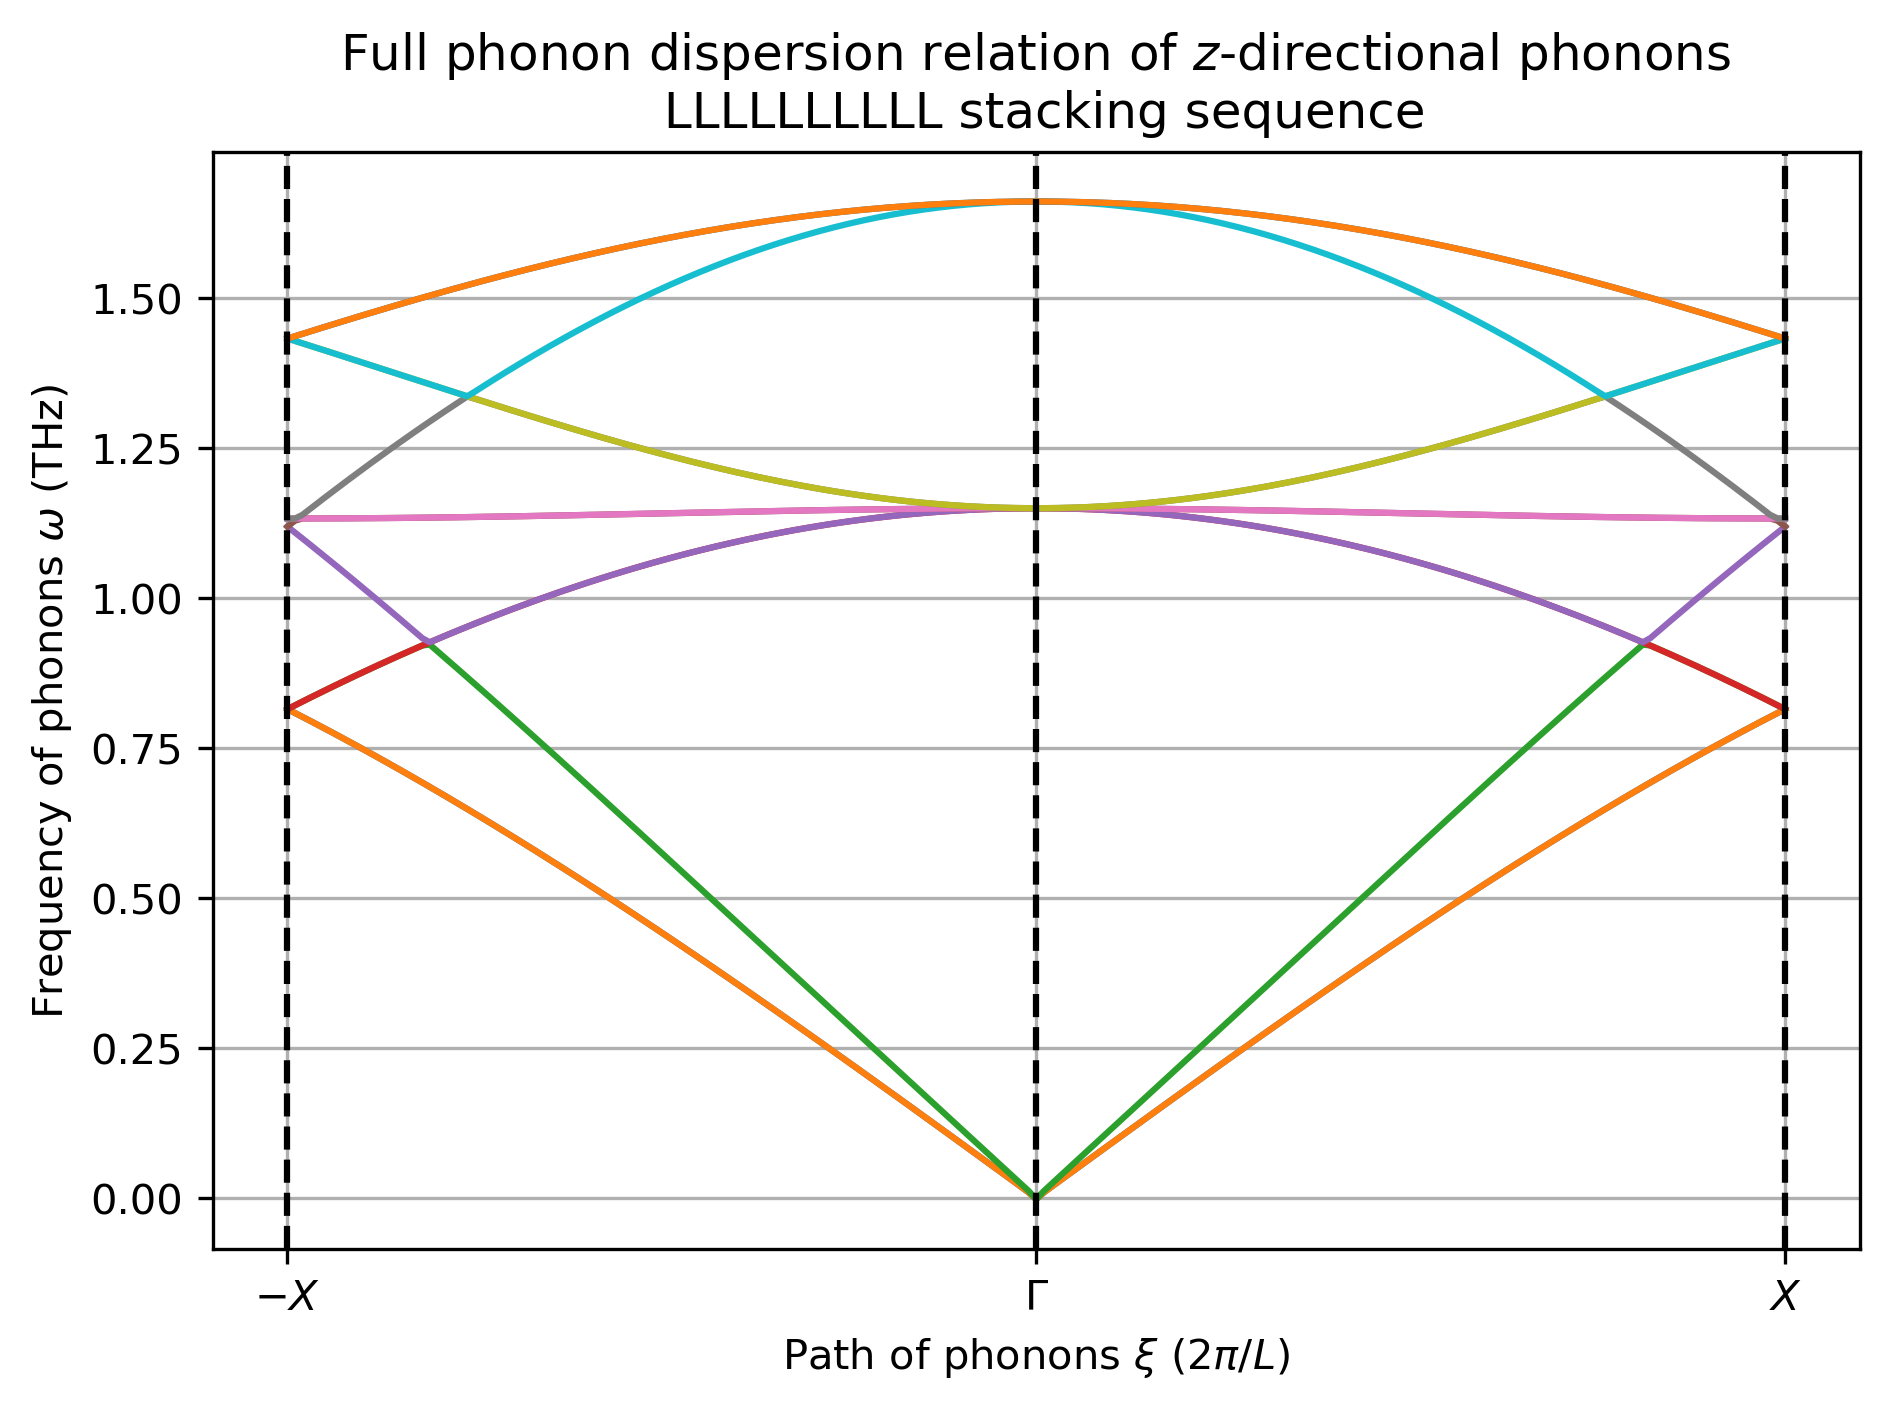

In [105]:
# Open yaml file
with open("orderedband_z.yaml", "r") as f:
    ordered_data_z = yaml.safe_load(f)

# Extract number of points and branches from yaml datafile
nqpoints = len(ordered_data_y["phonon"])
branches = 12

# Setup frequencies and paths
ordered_freqs_z = np.zeros((nqpoints, branches))
q = np.zeros(nqpoints)

# Loop over branches and points and store frequencies
for branch in range(branches):
    for point in range(nqpoints):
        ordered_freqs_z[point, branch] = ordered_data_z["phonon"][point]["band"][branch]["frequency"]
        q[point] = ordered_data_z["phonon"][point]["distance"]

plt.plot(q,ordered_freqs_z)
#plt.plot(q, LA_y, label="[010] direction (y)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Full phonon dispersion relation of $z$-directional phonons \n LLLLLLLLLL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.tight_layout()


## MONOATOMIC: Plotting longitudinal acoustic (LA) dispersion relations

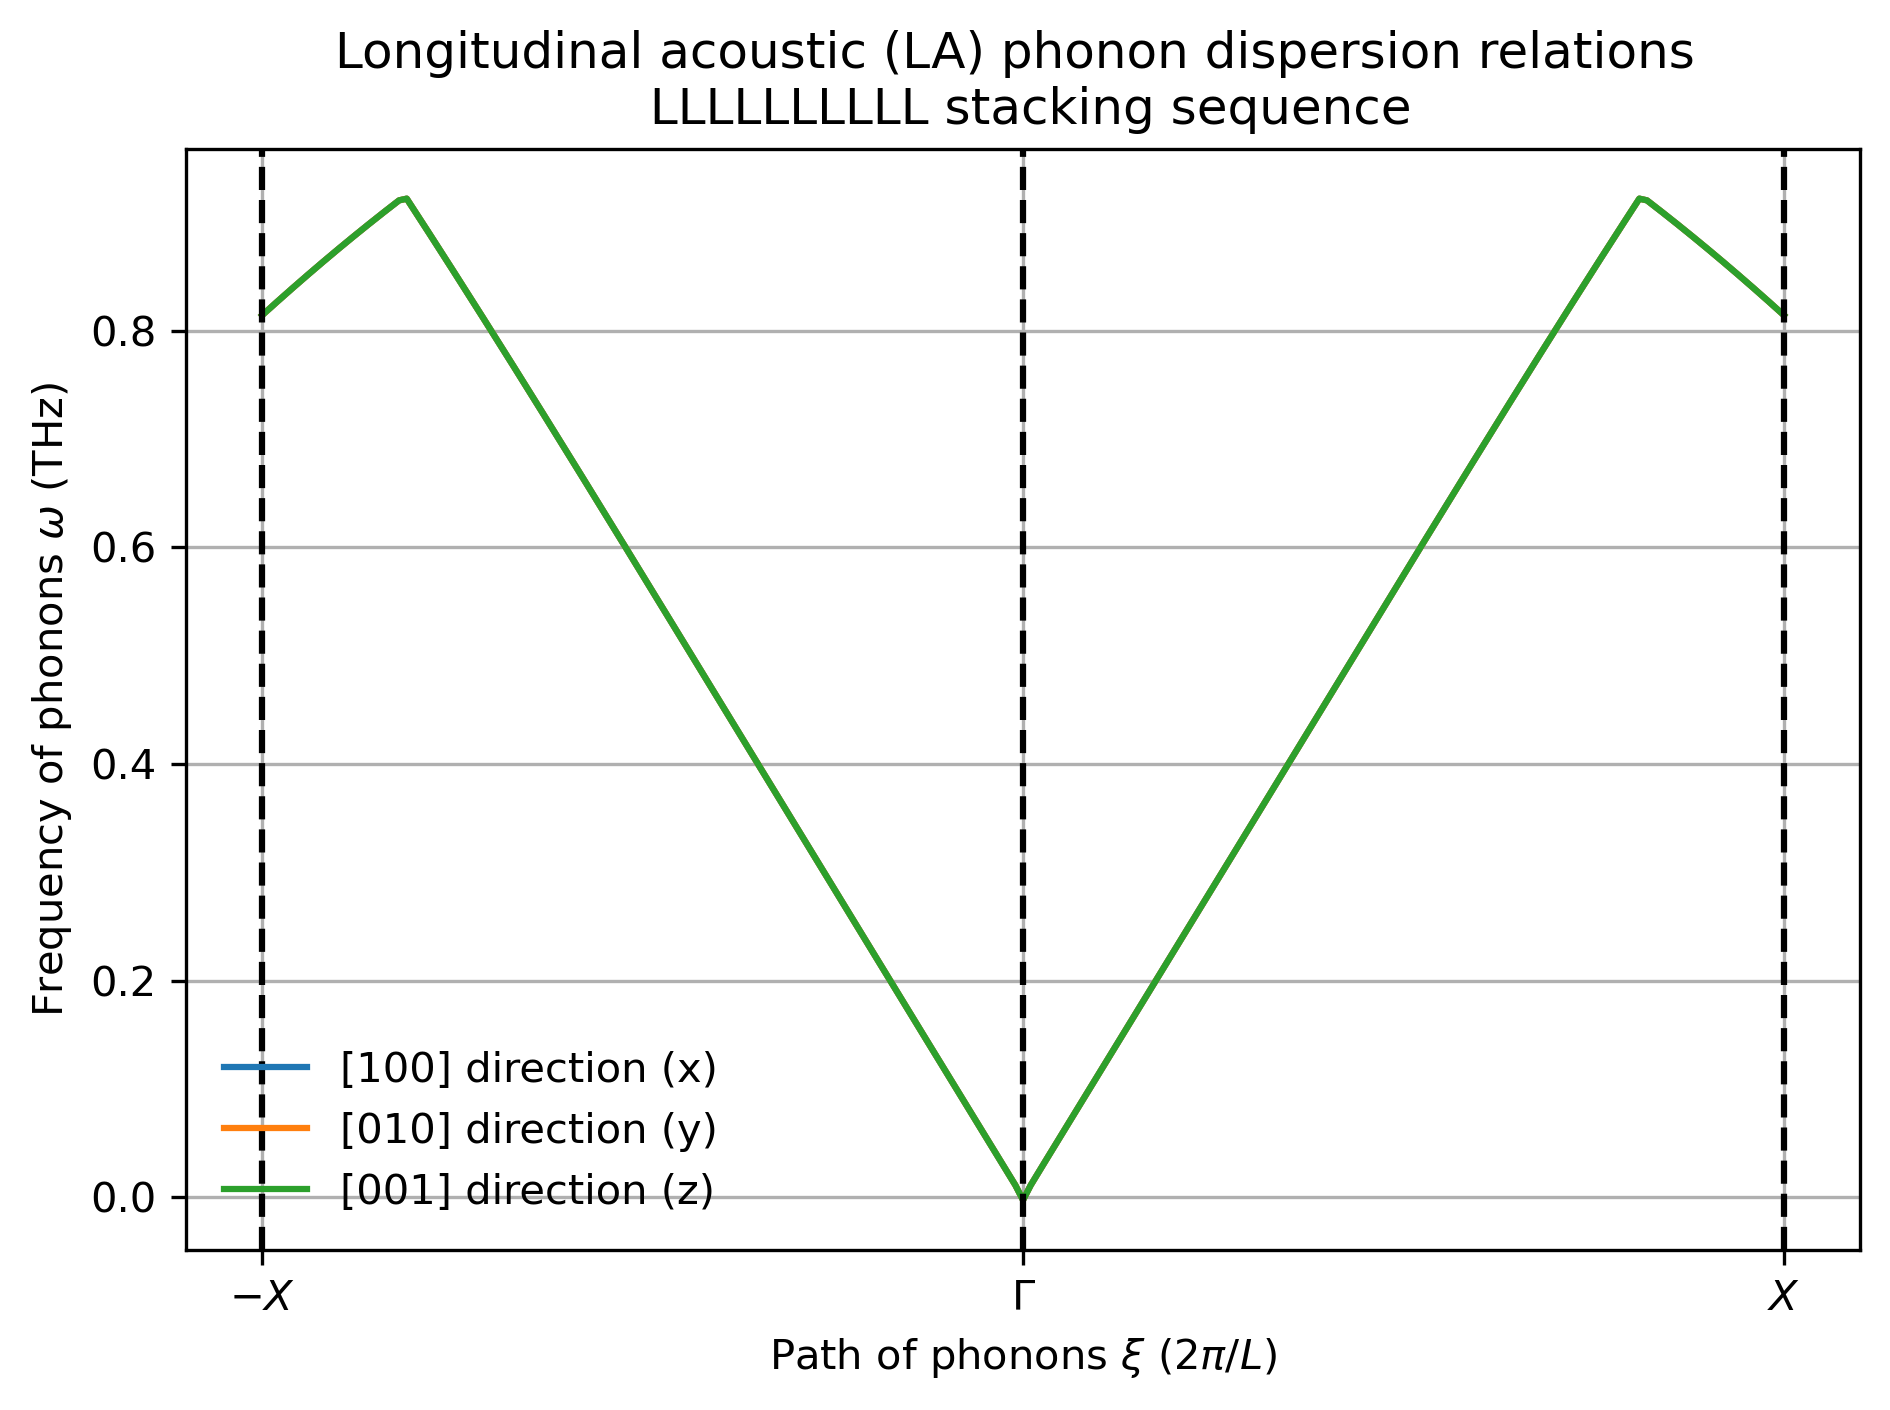

In [120]:
plt.plot(q,ordered_freqs_x[:,2], label="[100] direction (x)")
plt.plot(q,ordered_freqs_y[:,2], label="[010] direction (y)")
plt.plot(q,ordered_freqs_z[:,2], label="[001] direction (z)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Longitudinal acoustic (LA) phonon dispersion relations \n LLLLLLLLLL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.legend()
plt.tight_layout()

## DIATOMIC: Plotting phonon dispersion relation for x path

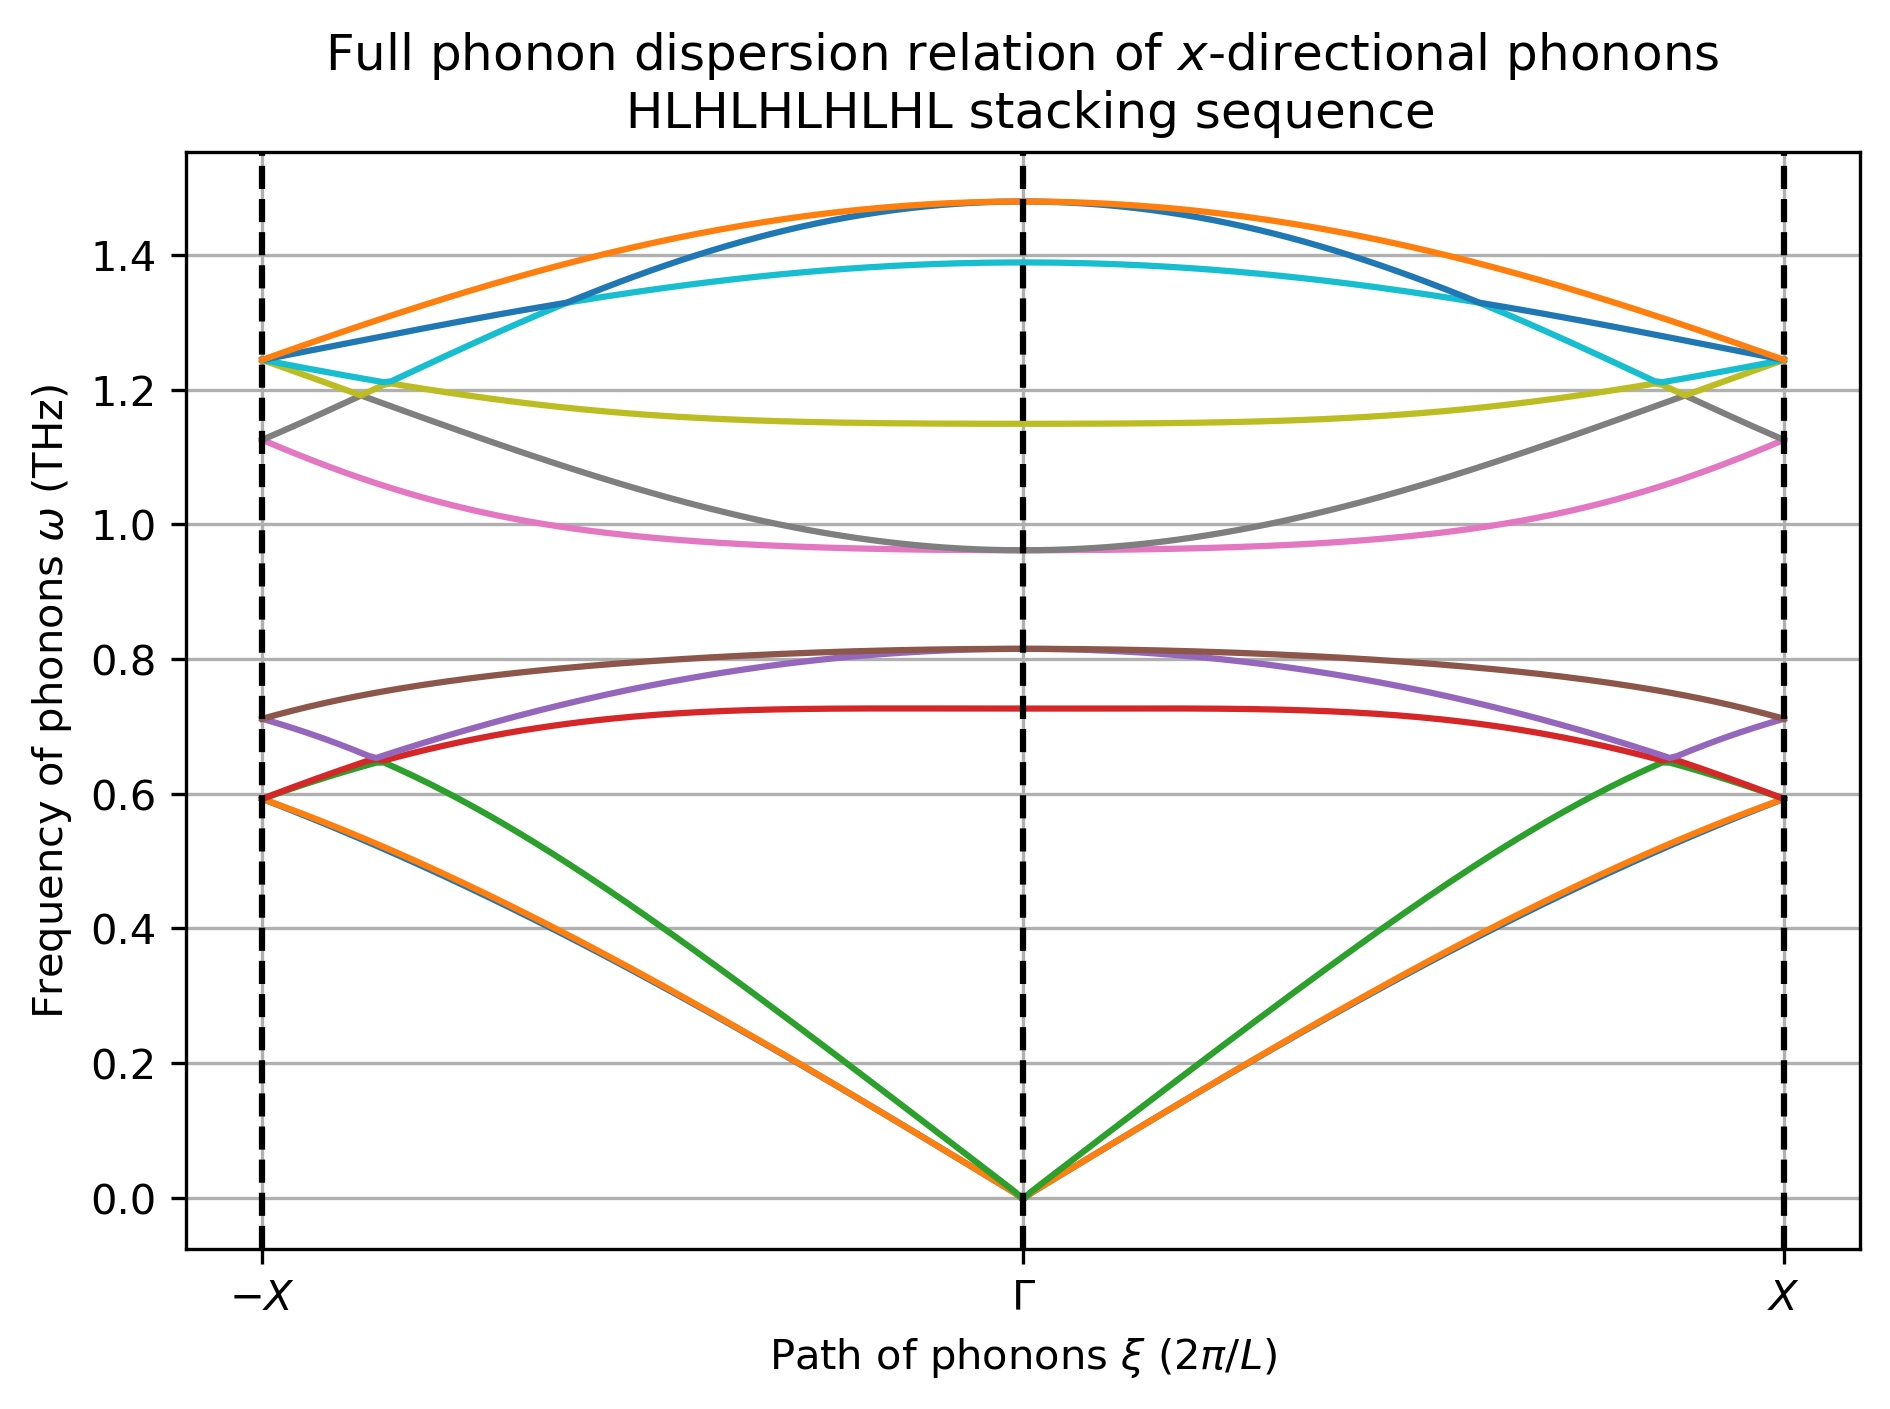

In [123]:
# Open yaml file
with open("disorderedband_x.yaml", "r") as f:
    disordered_data_x = yaml.safe_load(f)

# Extract number of points and branches from yaml datafile
nqpoints = len(disordered_data_x["phonon"])
branches = 12

# Setup frequencies and paths
disordered_freqs_x = np.zeros((nqpoints, branches))
q = np.zeros(nqpoints)

# Loop over branches and points and store frequencies
for branch in range(branches):
    for point in range(nqpoints):
        disordered_freqs_x[point, branch] = disordered_data_x["phonon"][point]["band"][branch]["frequency"]
        q[point] = disordered_data_x["phonon"][point]["distance"]

plt.plot(q,disordered_freqs_x)
#plt.plot(q, LA_y, label="[010] direction (y)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Full phonon dispersion relation of $x$-directional phonons \n HLHLHLHLHL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.tight_layout()


## DIATOMIC: Plotting phonon dispersion relation for y path

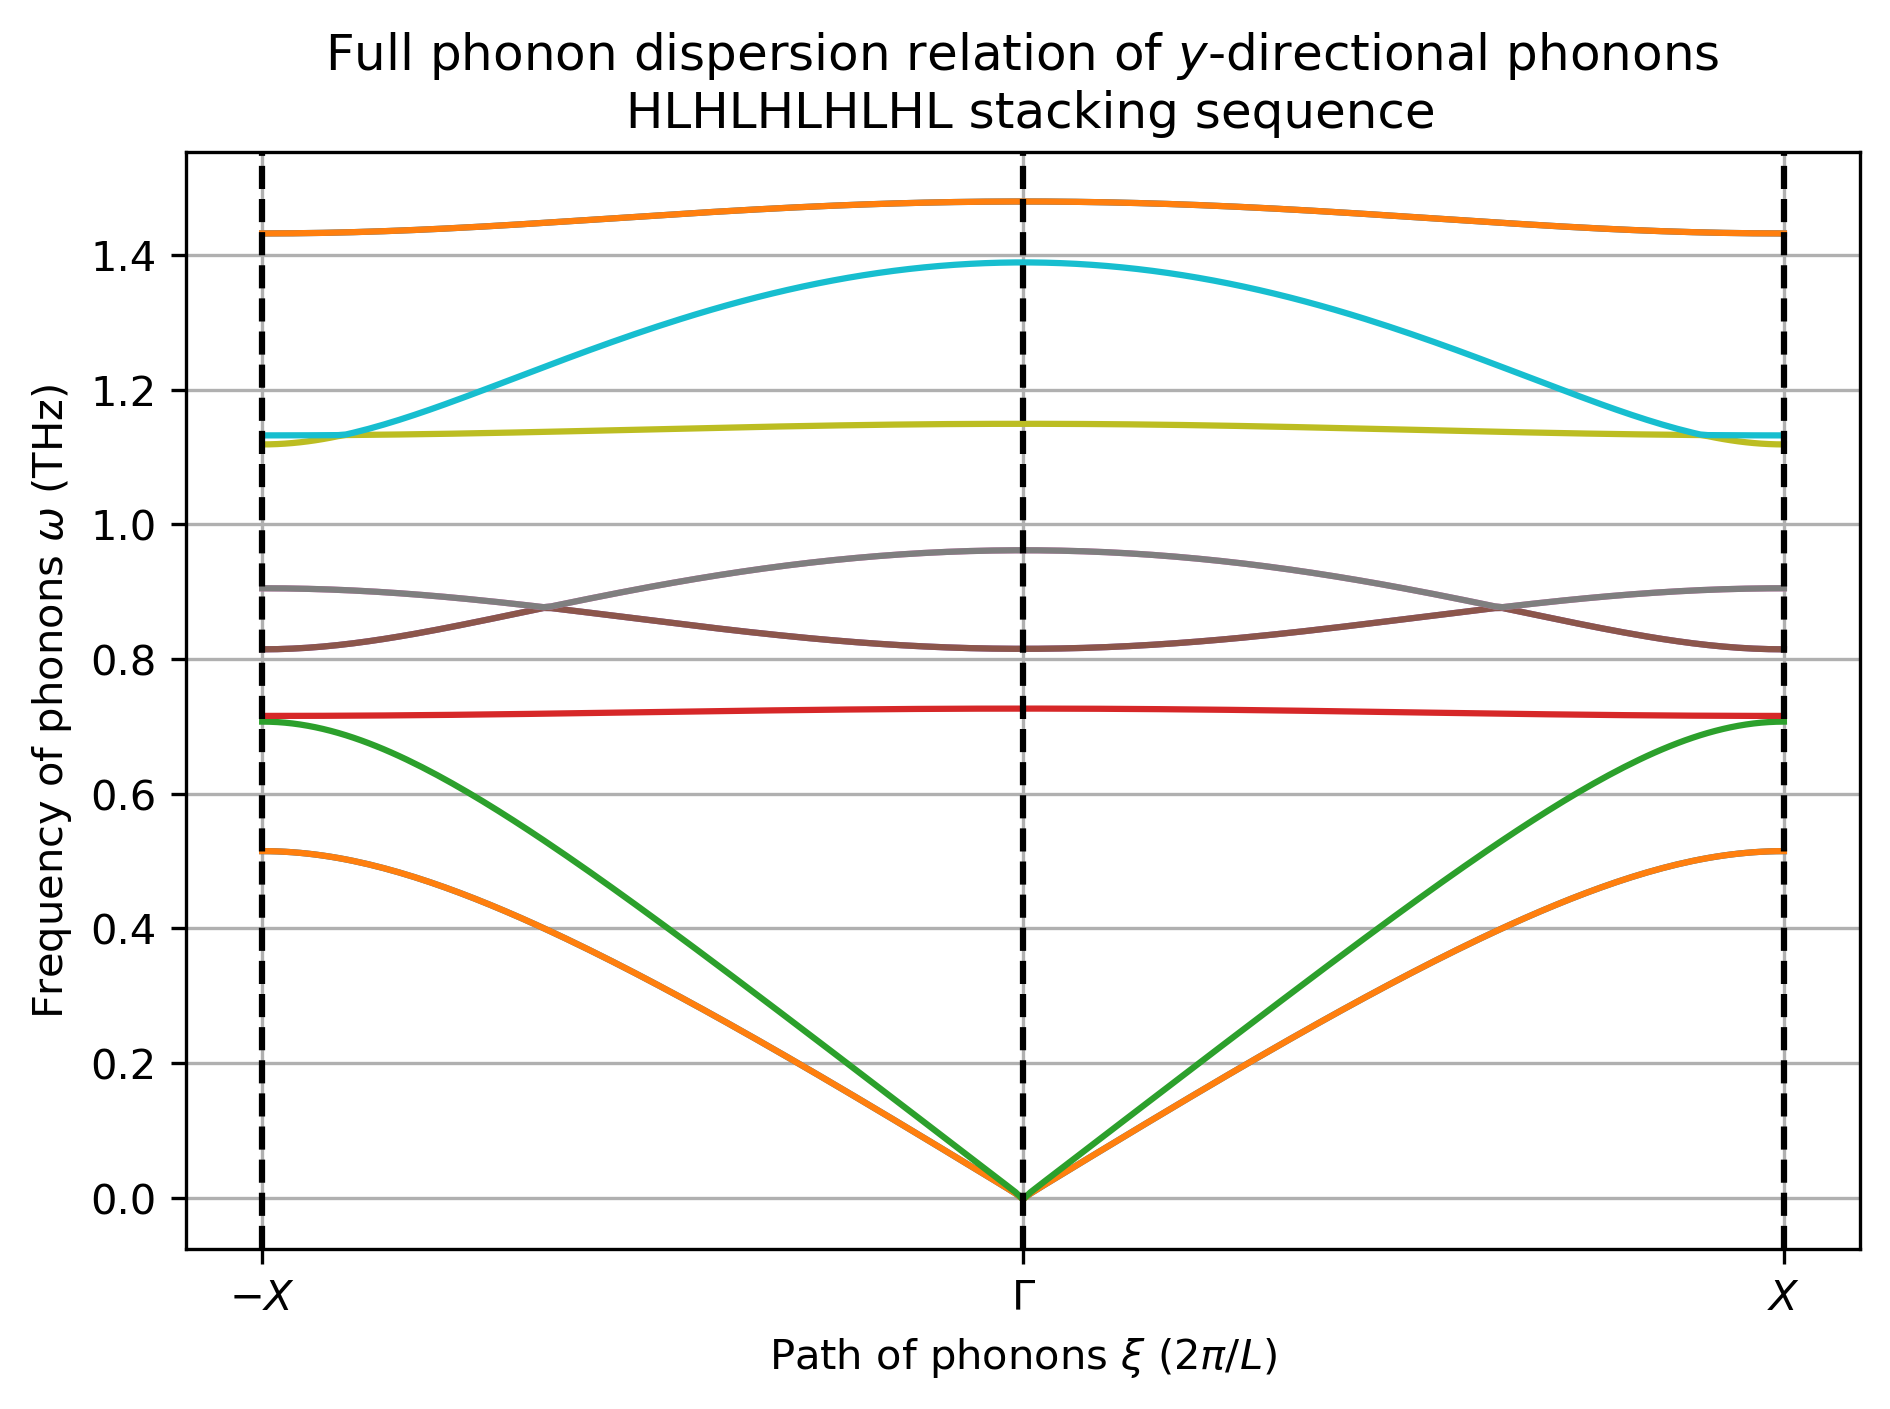

In [124]:
# Open yaml file
with open("disorderedband_y.yaml", "r") as f:
    disordered_data_y = yaml.safe_load(f)

# Extract number of points and branches from yaml datafile
nqpoints = len(disordered_data_y["phonon"])
branches = 12

# Setup frequencies and paths
disordered_freqs_y = np.zeros((nqpoints, branches))
q = np.zeros(nqpoints)

# Loop over branches and points and store frequencies
for branch in range(branches):
    for point in range(nqpoints):
        disordered_freqs_y[point, branch] = disordered_data_y["phonon"][point]["band"][branch]["frequency"]
        q[point] = disordered_data_y["phonon"][point]["distance"]

plt.plot(q,disordered_freqs_y)
#plt.plot(q, LA_y, label="[010] direction (y)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Full phonon dispersion relation of $y$-directional phonons \n HLHLHLHLHL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.tight_layout()


## DIATOMIC: Plotting phonon dispersion relation for z path

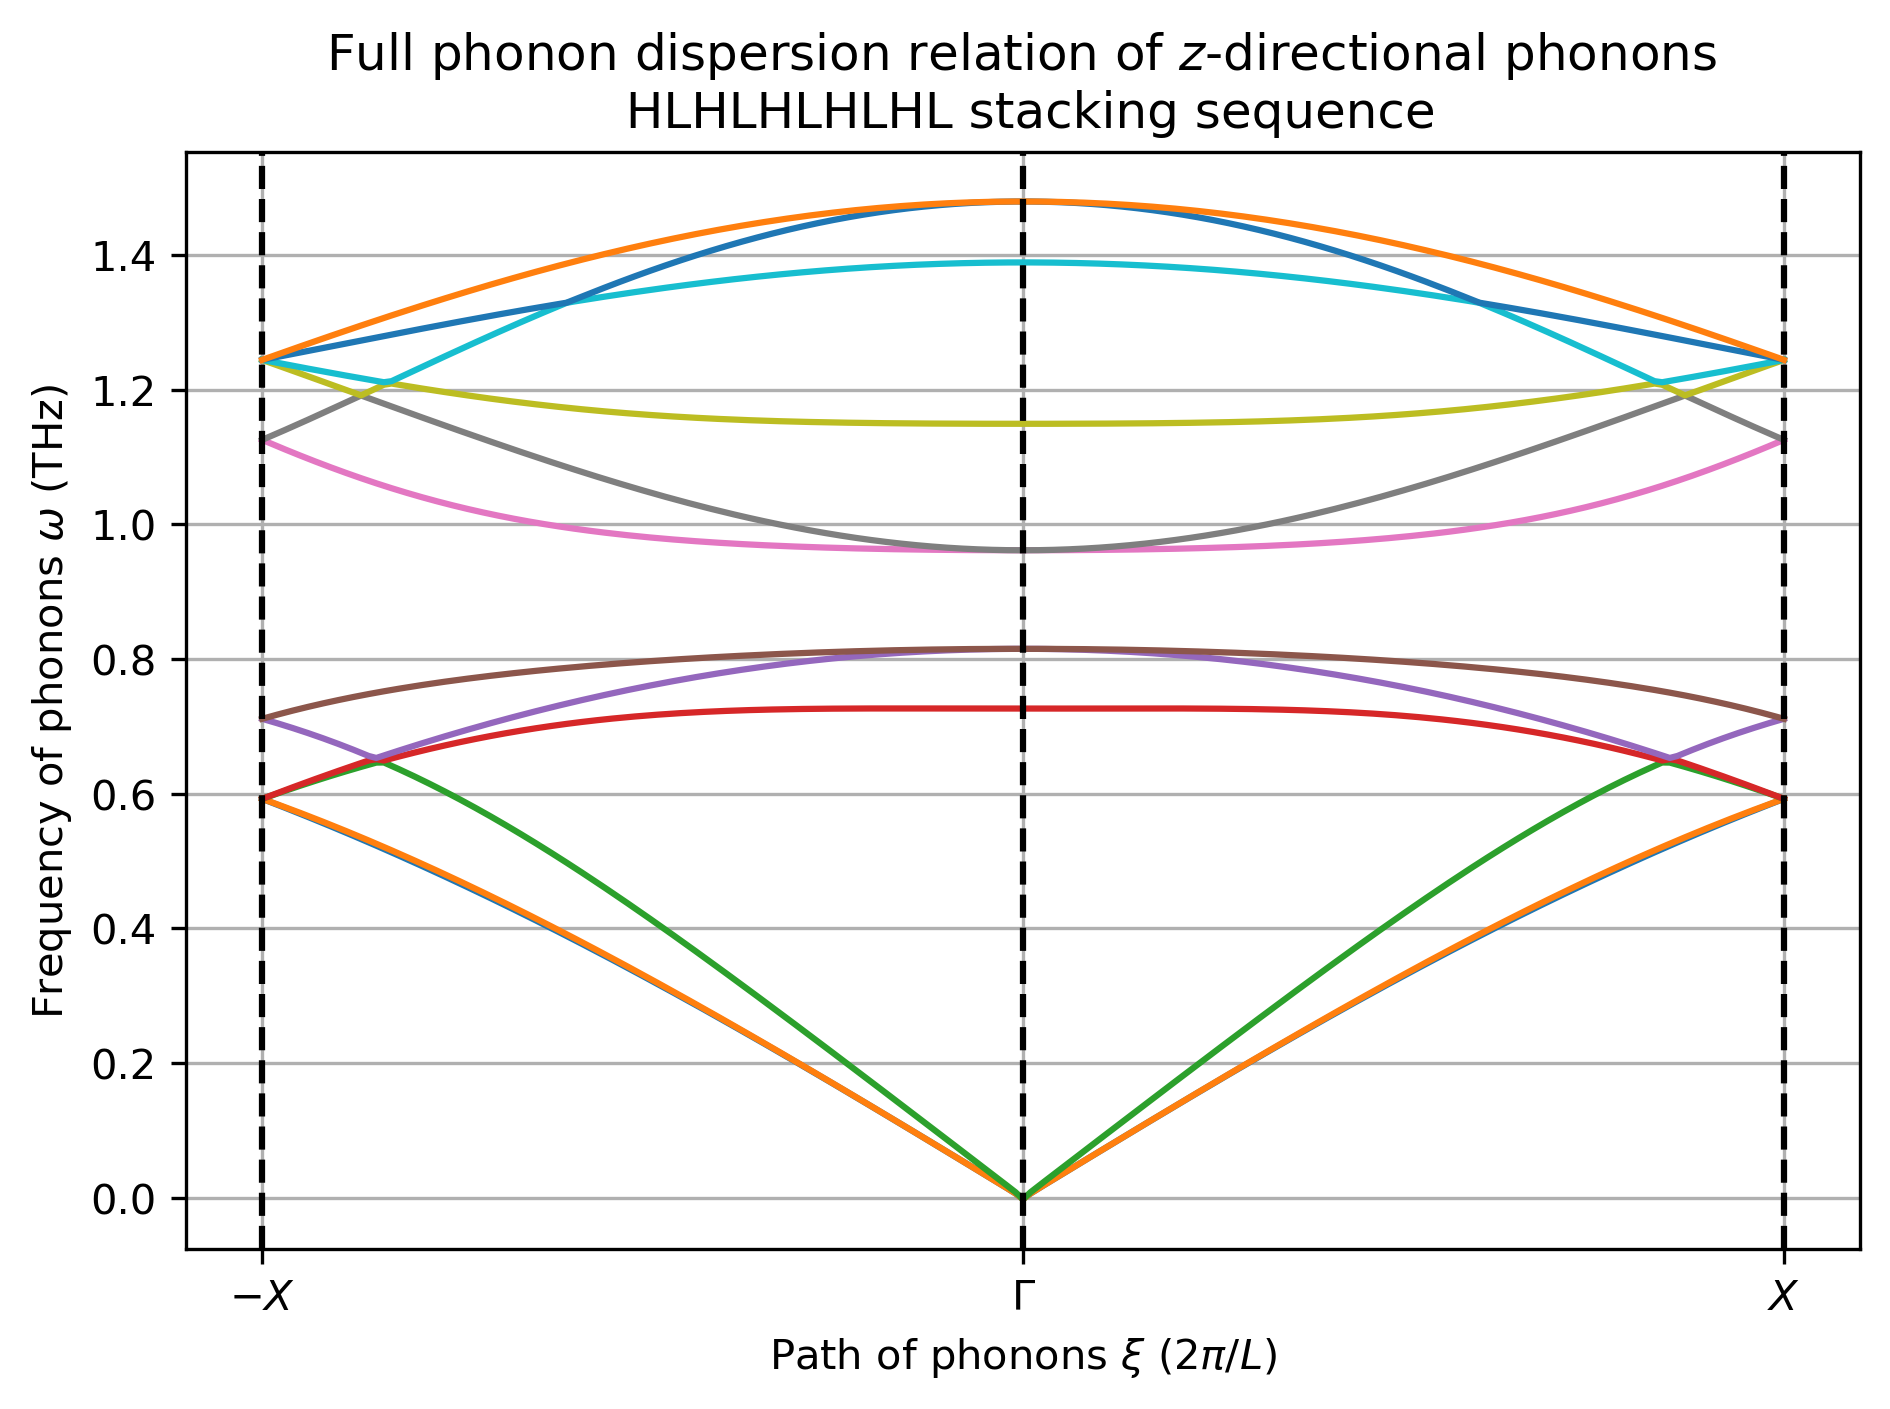

In [125]:
# Open yaml file
with open("disorderedband_z.yaml", "r") as f:
    disordered_data_z = yaml.safe_load(f)

# Extract number of points and branches from yaml datafile
nqpoints = len(disordered_data_z["phonon"])
branches = 12

# Setup frequencies and paths
disordered_freqs_z = np.zeros((nqpoints, branches))
q = np.zeros(nqpoints)

# Loop over branches and points and store frequencies
for branch in range(branches):
    for point in range(nqpoints):
        disordered_freqs_z[point, branch] = disordered_data_z["phonon"][point]["band"][branch]["frequency"]
        q[point] = disordered_data_z["phonon"][point]["distance"]

plt.plot(q,disordered_freqs_z)
#plt.plot(q, LA_y, label="[010] direction (y)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Full phonon dispersion relation of $z$-directional phonons \n HLHLHLHLHL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.tight_layout()


## DIATOMIC: Plotting longitudinal acoustic (LA) dispersion relations

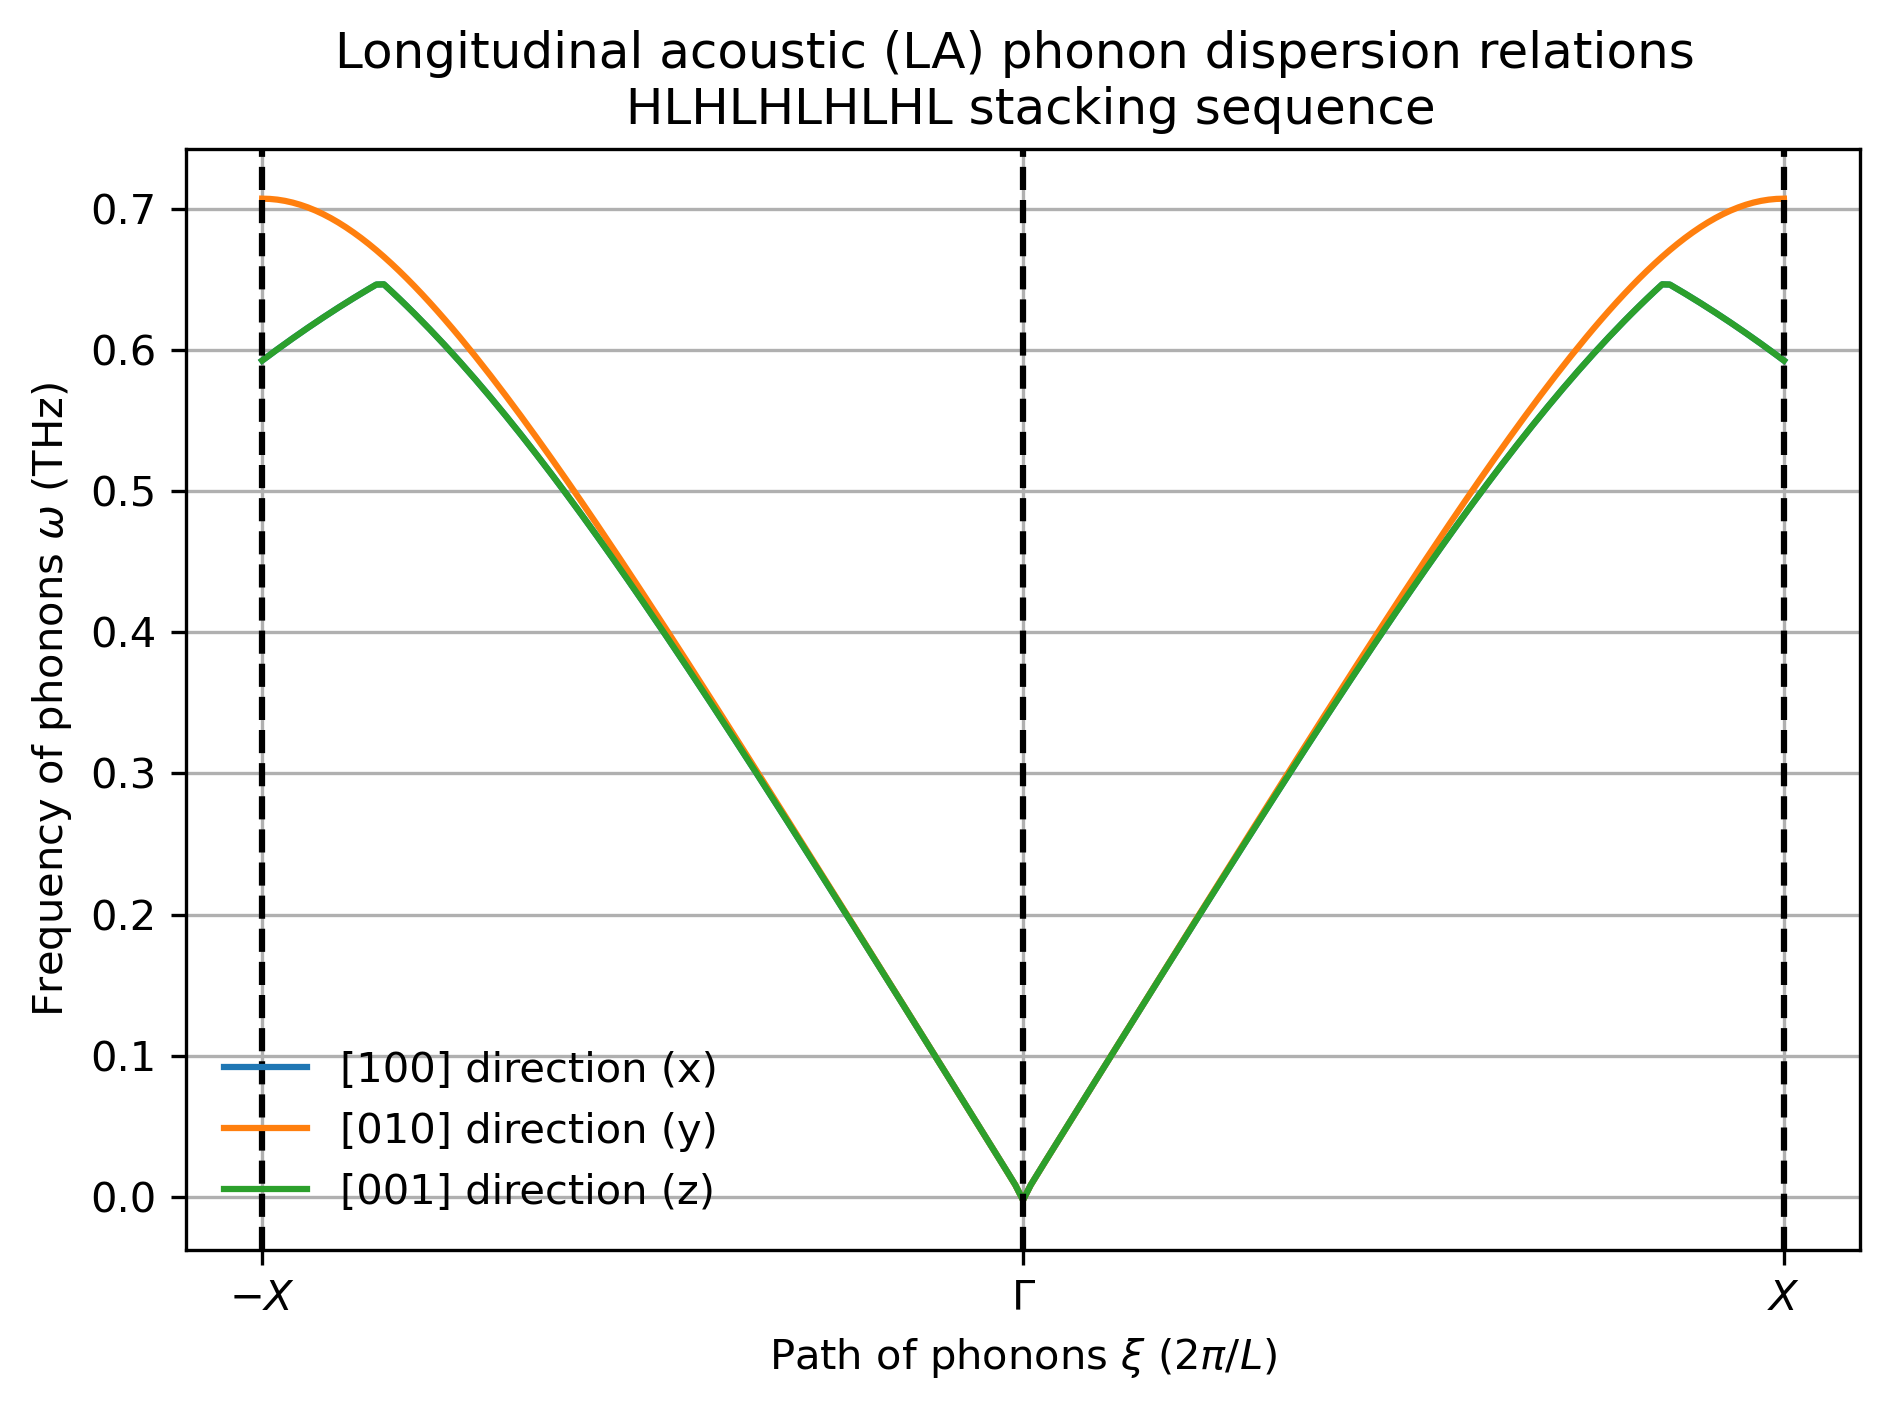

In [127]:
plt.plot(q,disordered_freqs_x[:,2], label="[100] direction (x)")
plt.plot(q,disordered_freqs_y[:,2], label="[010] direction (y)")
plt.plot(q,disordered_freqs_z[:,2], label="[001] direction (z)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Longitudinal acoustic (LA) phonon dispersion relations \n HLHLHLHLHL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.legend()
plt.tight_layout()

## DIATOMIC: Plotting transverse acoustic (TA) dispersion relations

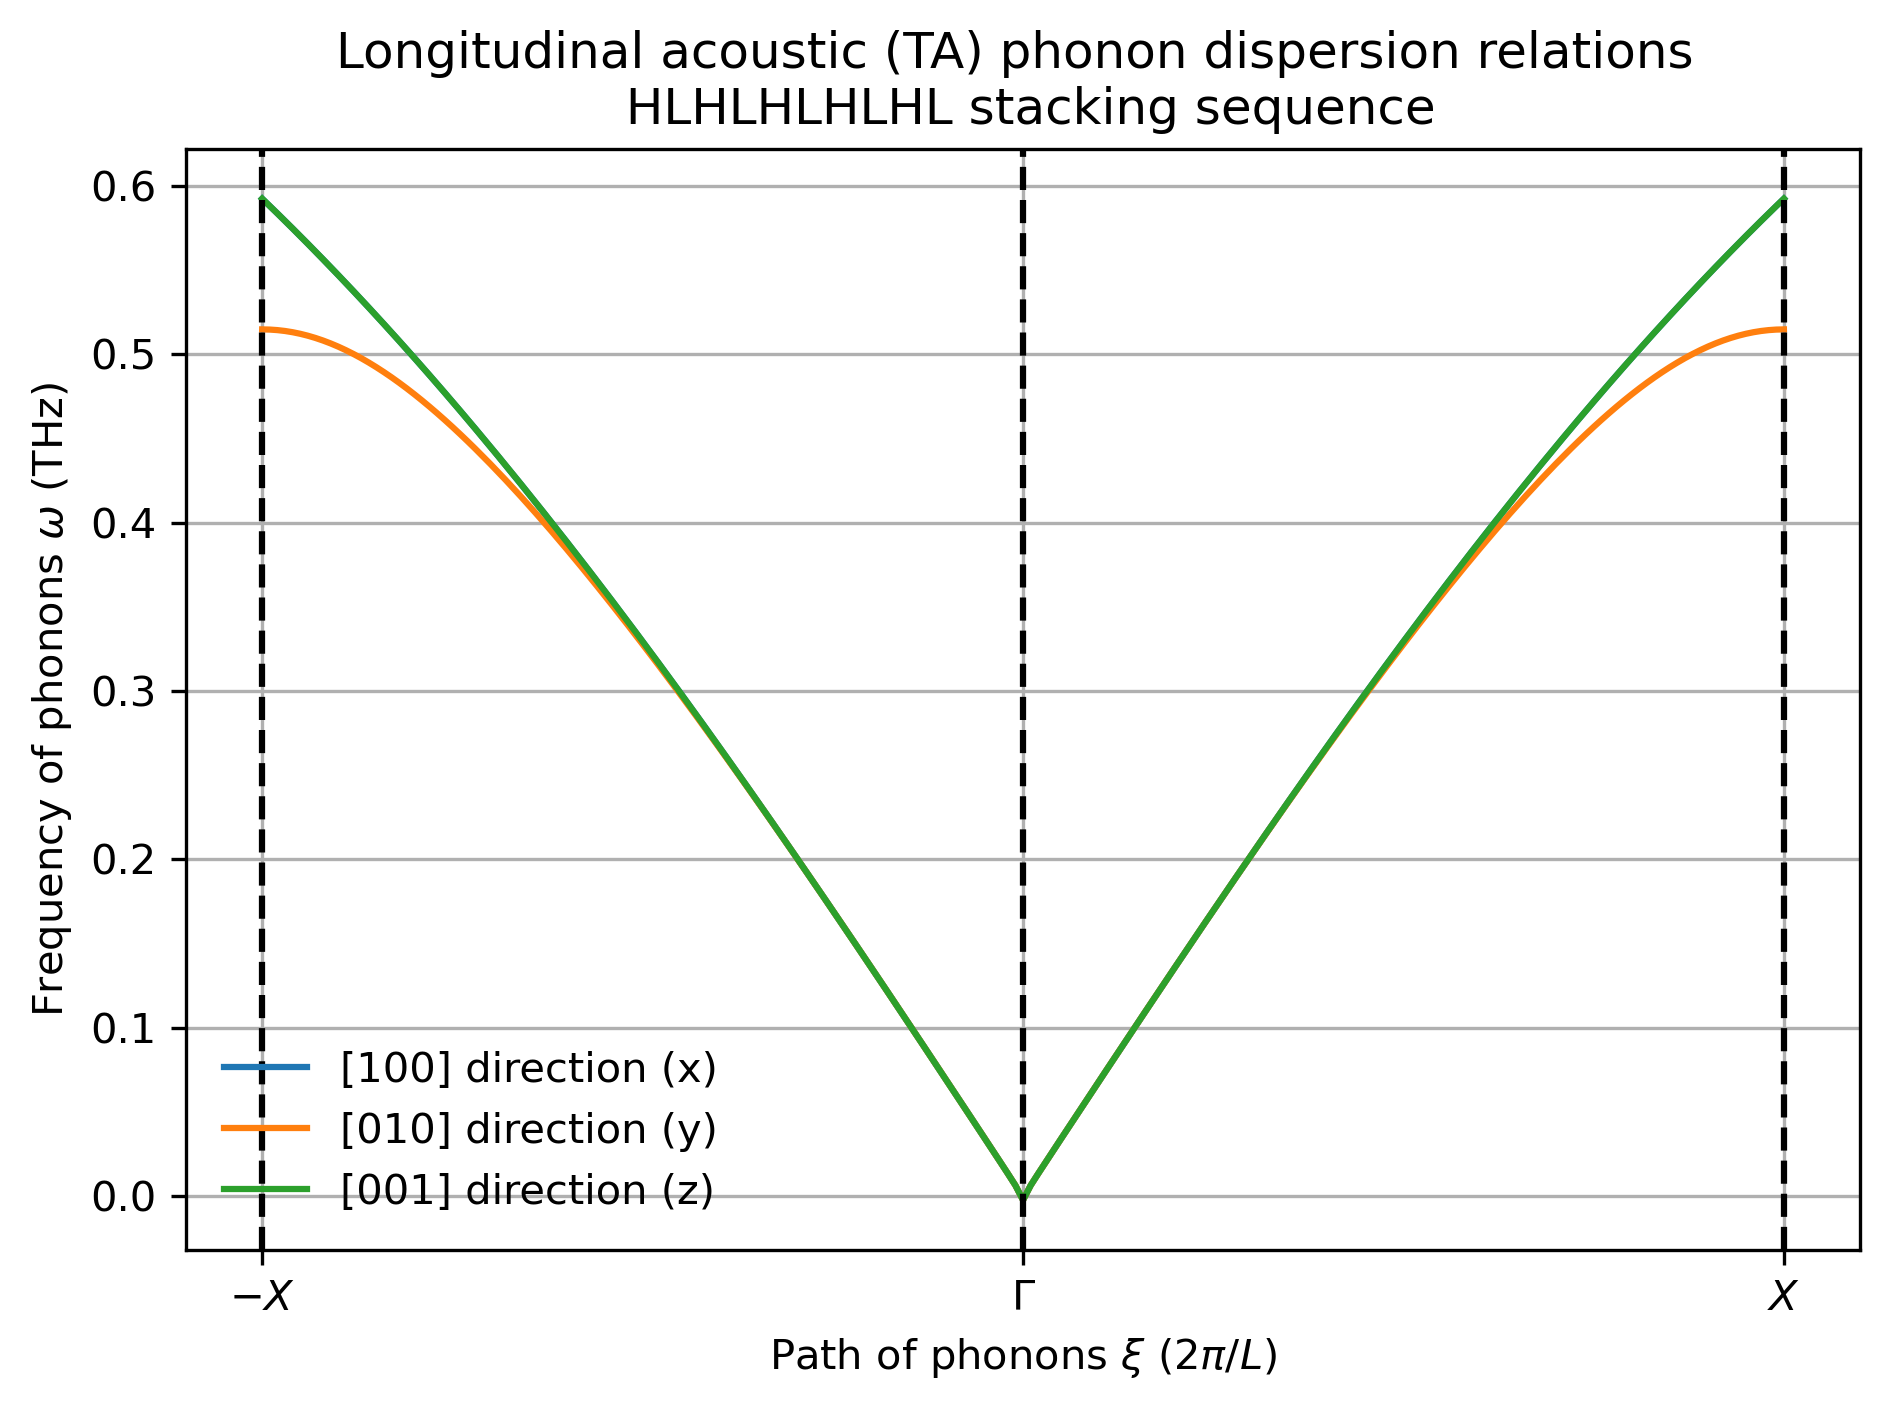

In [136]:
plt.plot(q,disordered_freqs_x[:,0], label="[100] direction (x)")
plt.plot(q,disordered_freqs_y[:,0], label="[010] direction (y)")
plt.plot(q,disordered_freqs_z[:,0], label="[001] direction (z)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Longitudinal acoustic (TA) phonon dispersion relations \n HLHLHLHLHL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.legend()
plt.tight_layout()

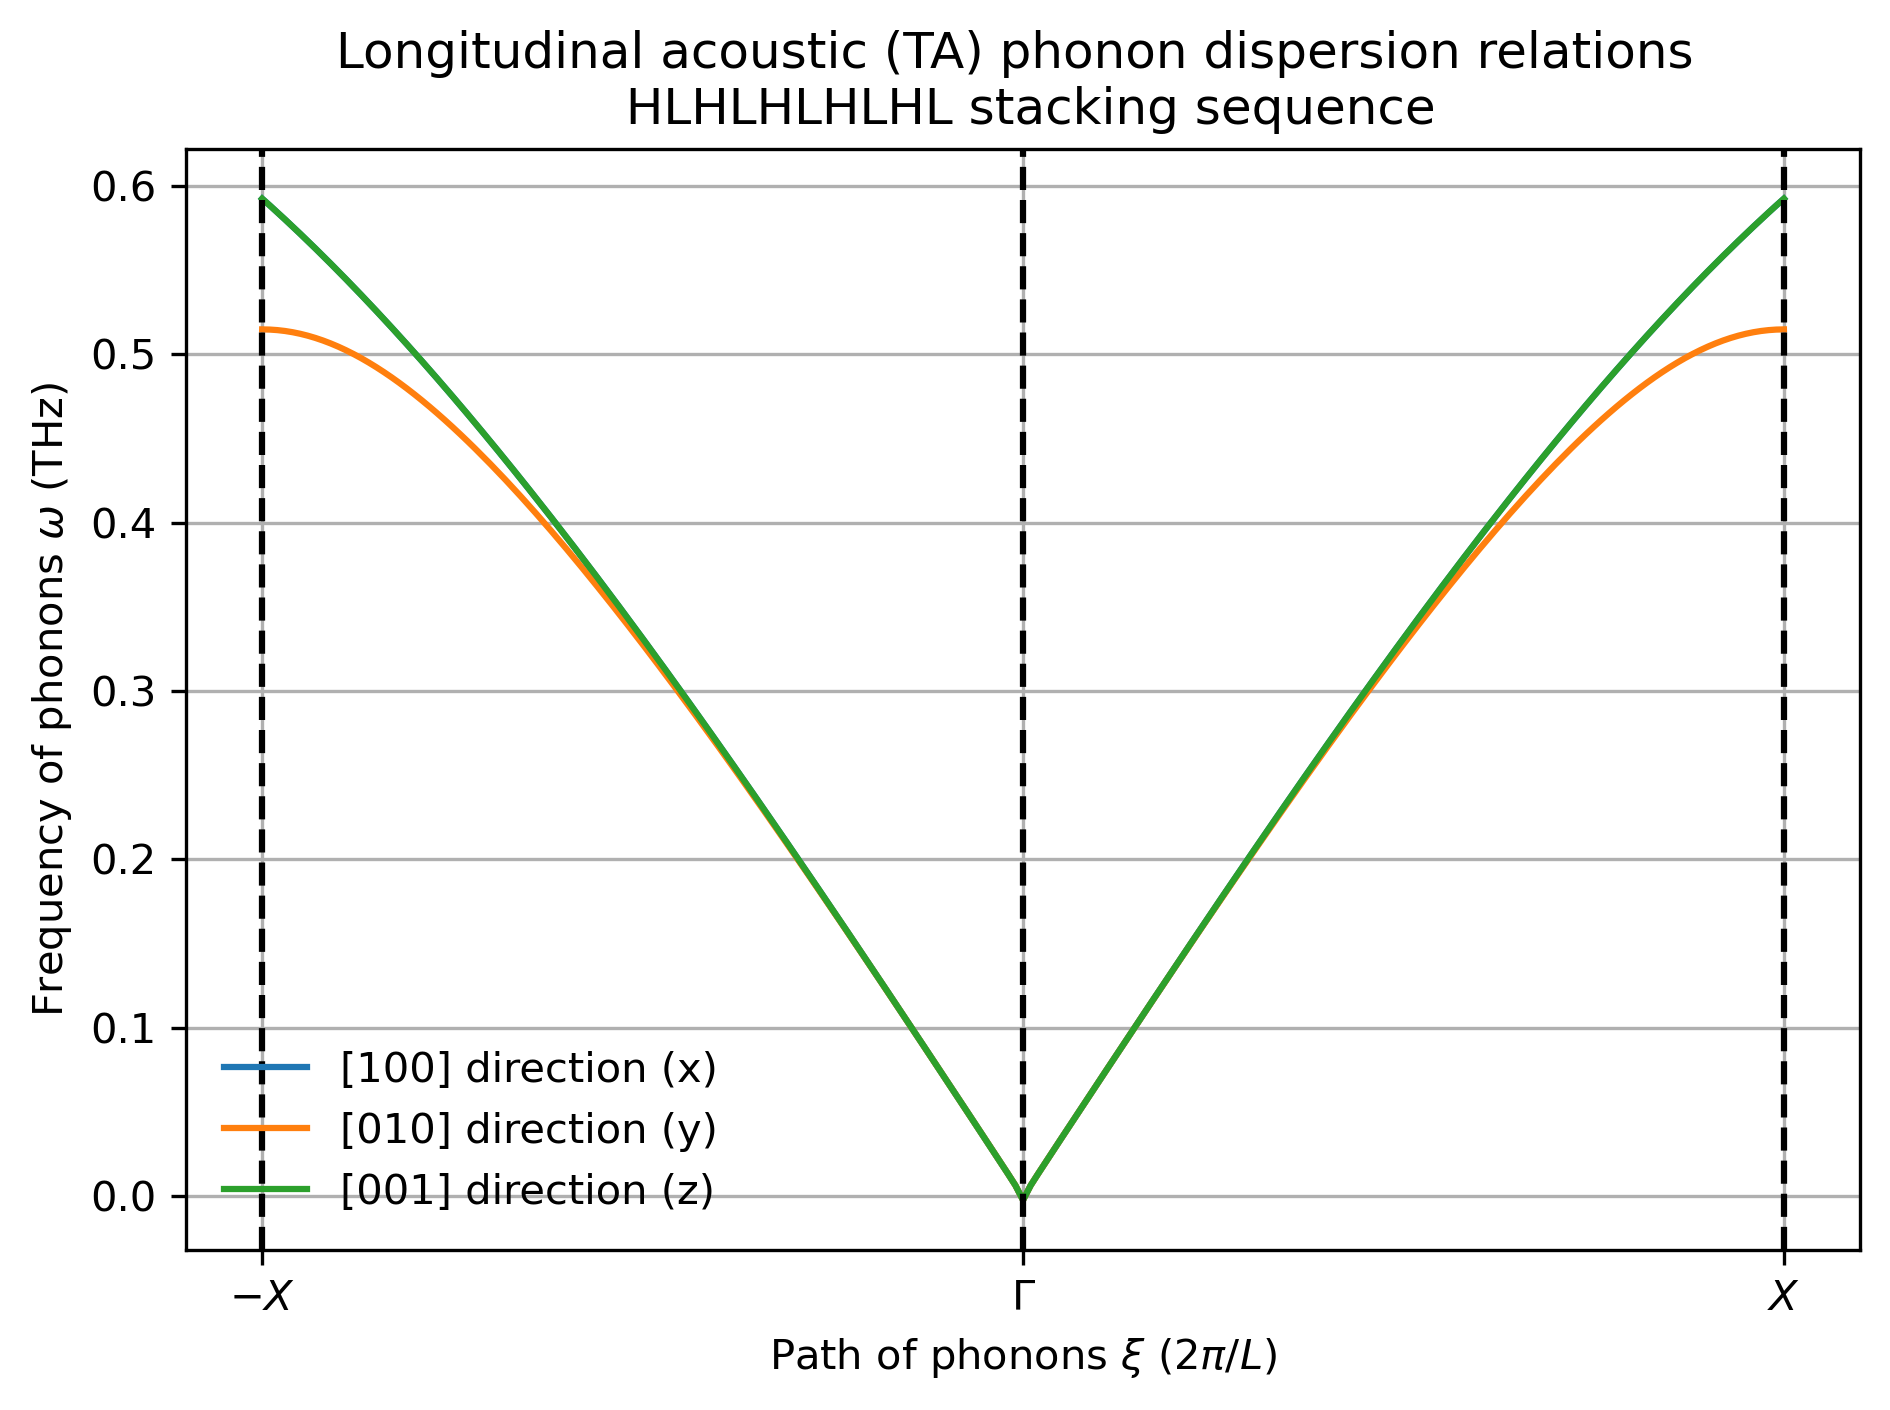

In [137]:
plt.plot(q,disordered_freqs_x[:,1], label="[100] direction (x)")
plt.plot(q,disordered_freqs_y[:,1], label="[010] direction (y)")
plt.plot(q,disordered_freqs_z[:,1], label="[001] direction (z)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Longitudinal acoustic (TA) phonon dispersion relations \n HLHLHLHLHL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.legend()
plt.tight_layout()

## Something which I want to do

Taken straight from phonopy documentation:

It is necessary to relax crystal structure before starting phonon calculation. At least vanishing residual forces on atoms are expected. Using LAMMPS, crystal structure can be optimized under different constraints. The following is the simplest optimization where only internal atomic positions are relaxed.

    variable etol equal 0.0
    variable ftol equal 1e-8
    variable maxiter equal 1000
    variable maxeval equal 100000
    
    minimize ${etol} ${ftol} ${maxiter} ${maxeval}
    
    write_data dump.unitcell